In [88]:
import os
import numpy as np
import argparse
# from ouster import client, pcap
from ouster.sdk import client, pcap
from contextlib import closing
from more_itertools import nth
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import math

In [91]:
# Sensor Configuration
data_dim = [32, 2048]
deg_left = 140
deg_right = 220

In [106]:
pixel_ratio = data_dim[1]/360
left_pixel = math.floor(deg_left * pixel_ratio / 10) * 10
right_pixel = math.ceil(deg_right * pixel_ratio / 10) * 10
left_pixel -= 1
right_pixel -= 1
data_dim = right_pixel-left_pixel
print(left_pixel, right_pixel)

789 1259


470

In [120]:
folder_path =  r"D:\LiDAR\RawData"
folders = ["18_09_2024_2gSodium","20_09_2024_2gSodium","24_10_2024_2gSodium"]
degen_start_time = np.array([127, 140, 125]) * 10
folder_list = [folder_path + "\\" + i for i in folders]
folder_list

['D:\\LiDAR\\RawData\\18_09_2024_2gSodium',
 'D:\\LiDAR\\RawData\\20_09_2024_2gSodium',
 'D:\\LiDAR\\RawData\\24_10_2024_2gSodium']

# Extract data from Full format experiments

In [103]:
def StatisticalCalc(frame):
    params = []
    for ind in range(frame.shape[-1]):
        data = frame[:,:,ind].flatten()        
        meanval = np.mean(data)
        varval = np.std(data)
        medval = np.median(data)
        q1val = np.percentile(data, 25)
        q3val = np.percentile(data, 75)
        minval = np.min(data)
        maxval = np.max(data)
        ptsval = np.count_nonzero(data)
        skewval = skew(data)
        kurtval = kurtosis(data)
        params.extend([meanval, varval, minval, q1val, medval, q3val, maxval, skewval, kurtval, ptsval])
    return params

In [121]:
folders = folder_list
fps = 10
df = pd.DataFrame(index = np.arange(30000), 
                  columns=['Exp', 'Folder', 'Mode', 'Frame', 
                           'MeanR', 'VarR', 'MinR', 'Q1R','MedR', 'Q3R','MaxR', 'SkewR', 'KurtR','PtsR',
                           'MeanSig', 'VarSig','MinSig', 'Q1Sig','MedSig', 'Q3Sig','MaxSig','SkewSig', 'KurtSig','PtsSig', 
                           'MeanRef', 'VarRef', 'MinRef','Q1Ref', 'MedRef', 'Q3Ref','MaxRef','SkewRef', 'KurtRef','PtsRef',
                           'MeanIR', 'VarIR', 'MinIR','Q1IR','MedIR', 'Q3IR','MaxIR', 'SkewIR', 'KurtIR','PtsIR'])
row_counter = 0
folder_count = -1
for folder in folders:
    folder_count += 1
    rootfolder = folder.split("\\")[-1]
    for subfolder in os.listdir(folder):
        full_path = folder + "\\" + subfolder
        if "Full" not in subfolder:
            continue
        counter = 0
        if os.path.isdir(full_path):
            file_name = 'OS-1-32-122147000654-2048x10'
            intdata = np.empty(shape=(32,data_dim, 4, 1))
            fulldata = np.empty(shape=(32,data_dim, 4, 1))
            frame_counter = 0
            if os.path.isfile(full_path + "\\" + file_name + '.json') :
                metadata_path = full_path + "\\" + file_name + '.json'
                pcap_path = full_path + "\\" + file_name + '.pcap'
                print(f"File {metadata_path} Located...")
                with open(metadata_path, 'r') as f:                    
                    metadata = client.SensorInfo(f.read())
                    print(f"Loading {pcap_path} File...")
                    source = pcap.Pcap(pcap_path, metadata)
                    with closing(client.Scans(source)) as scans:
                        for scan in tqdm(scans):
                            rangedata = client.destagger(metadata, scan.field(client.ChanField.RANGE))
                            rangedata = rangedata[:, left_pixel:right_pixel]
                            sigdata = client.destagger(metadata, scan.field(client.ChanField.SIGNAL)) 
                            sigdata = sigdata[:, left_pixel:right_pixel]
                            refdata = client.destagger(metadata, scan.field(client.ChanField.REFLECTIVITY))
                            refdata = refdata[:, left_pixel:right_pixel]
                            irdata = client.destagger(metadata, scan.field(client.ChanField.NEAR_IR))
                            irdata = irdata[:, left_pixel:right_pixel]
                            testdata = np.stack([rangedata, sigdata, refdata, irdata], axis=-1)
                            if counter >= degen_start_time[folder_count]:                                 
                                if frame_counter < 10:                             
                                    intdata = np.concatenate([intdata, np.expand_dims(testdata, axis=-1)], axis=3) 
                                    frame_counter += 1
                                else:
                                    frame_counter = 0
                                    MeanFrame = np.mean(intdata[:,:,:,1:], axis=3)
                                    header = [rootfolder, subfolder, 'Degen', counter]
                                    statparams = StatisticalCalc(MeanFrame)                                
                                    df.iloc[row_counter] = header + statparams
                                    intdata = np.empty(shape=(32,data_dim, 4, 1))
                                    intdata = np.concatenate([intdata, np.expand_dims(testdata, axis=-1)], axis=3) 
                                    frame_counter += 1
                                    row_counter += 1
                                    counter += 1
                            else:
                                MeanFrame = testdata
                                header = [rootfolder, subfolder, 'Gen', counter]
                                statparams = StatisticalCalc(MeanFrame)                                
                                df.loc[row_counter] = header + statparams                                
                                row_counter += 1
                                counter += 1
            
df.dropna(inplace=True)
df.to_csv("ConsolidatedData.csv")                  

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\3574986368.py:31: DeprecationWarning: pcap.Pcap(...) is deprecated: Use pcap.PcapMultiPacketReader(...).single_source(0) instead. This API is planned to be removed in Q4 2024.
  source = pcap.Pcap(pcap_path, metadata)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\3574986368.py:32: DeprecationWarning: client.Scans(...) is deprecated: Use client.ScansMulti(...).single_source(0) or the appropriate scan source directly instead. This API is planned to be removed in Q4 2024.
  with closing(client.Scans(source)) as scans:


File D:\LiDAR\RawData\18_09_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\18_09_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1270it [00:28, 43.84it/s]


In [108]:
# 08 Apr 2024 Experiment data extraction
folders = [r"D:\LiDAR\RawData\08_04_2024_2gSodiumForDA"]
fps = 10
df_exp4 = pd.DataFrame(index = np.arange(30000), 
                  columns=['Exp', 'Folder', 'Mode', 'Frame', 
                           'MeanR', 'VarR', 'MinR', 'Q1R','MedR', 'Q3R','MaxR', 'SkewR', 'KurtR','PtsR',
                           'MeanSig', 'VarSig','MinSig', 'Q1Sig','MedSig', 'Q3Sig','MaxSig','SkewSig', 'KurtSig','PtsSig', 
                           'MeanRef', 'VarRef', 'MinRef','Q1Ref', 'MedRef', 'Q3Ref','MaxRef','SkewRef', 'KurtRef','PtsRef',
                           'MeanIR', 'VarIR', 'MinIR','Q1IR','MedIR', 'Q3IR','MaxIR', 'SkewIR', 'KurtIR','PtsIR'])
row_counter = 0
folder_count = -1
for folder in folders:
    folder_count += 1
    rootfolder = folder.split("\\")[-1]
    for subfolder in os.listdir(folder):
        full_path = folder + "\\" + subfolder
        counter = 0
        if os.path.isdir(full_path):
            file_name = 'OS-1-32-122147000654-2048x10'
            intdata = np.empty(shape=(32,data_dim, 4, 1))
            fulldata = np.empty(shape=(32,data_dim, 4, 1))
            frame_counter = 0
            if os.path.isfile(full_path + "\\" + file_name + '.json') :
                metadata_path = full_path + "\\" + file_name + '.json'
                pcap_path = full_path + "\\" + file_name + '.pcap'
                print(f"File {metadata_path} Located...")
                with open(metadata_path, 'r') as f:                    
                    metadata = client.SensorInfo(f.read())
                    print(f"Loading {pcap_path} File...")
                    source = pcap.Pcap(pcap_path, metadata)
                    with closing(client.Scans(source)) as scans:
                        for scan in tqdm(scans):
                            rangedata = client.destagger(metadata, scan.field(client.ChanField.RANGE))
                            rangedata = rangedata[:, left_pixel:right_pixel]
                            sigdata = client.destagger(metadata, scan.field(client.ChanField.SIGNAL)) 
                            sigdata = sigdata[:, left_pixel:right_pixel]
                            refdata = client.destagger(metadata, scan.field(client.ChanField.REFLECTIVITY))
                            refdata = refdata[:, left_pixel:right_pixel]
                            irdata = client.destagger(metadata, scan.field(client.ChanField.NEAR_IR))
                            irdata = irdata[:, left_pixel:right_pixel]                            
                            testdata = np.stack([rangedata, sigdata, refdata, irdata], axis=-1)
                            if "00" not in subfolder:                                
                                if frame_counter < 10:                             
                                    intdata = np.concatenate([intdata, np.expand_dims(testdata, axis=-1)], axis=3) 
                                    frame_counter += 1
                                else:
                                    frame_counter = 0
                                    MeanFrame = np.mean(intdata[:,:,:,1:], axis=3)
                                    header = [rootfolder, subfolder, 'Degen', counter]
                                    statparams = StatisticalCalc(MeanFrame)                                
                                    df_exp4.iloc[row_counter] = header + statparams
                                    intdata = np.empty(shape=(32,data_dim, 4, 1))
                                    row_counter += 1
                                    counter += 1
                            else:
                                MeanFrame = testdata
                                header = [rootfolder, subfolder, 'Gen', counter]
                                statparams = StatisticalCalc(MeanFrame)                                
                                df_exp4.loc[row_counter] = header + statparams                                
                                row_counter += 1
                                counter += 1    
df_exp4.dropna(inplace=True)
df_exp4.to_csv("Experiment4Data.csv")                  

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\918713514.py:30: DeprecationWarning: pcap.Pcap(...) is deprecated: Use pcap.PcapMultiPacketReader(...).single_source(0) instead. This API is planned to be removed in Q4 2024.
  source = pcap.Pcap(pcap_path, metadata)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\918713514.py:31: DeprecationWarning: client.Scans(...) is deprecated: Use client.ScansMulti(...).single_source(0) or the appropriate scan source directly instead. This API is planned to be removed in Q4 2024.
  with closing(client.Scans(source)) as scans:


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\00\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\00\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1532it [00:30, 50.00it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\01\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\01\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1007it [00:10, 95.09it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\02\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\02\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1063it [00:12, 83.77it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\03\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\03\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1209it [00:15, 75.61it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\04\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\04\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1164it [00:13, 86.00it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\05\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\05\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


348it [00:04, 84.55it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\06\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\06\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1028it [00:11, 90.56it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\07\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\07\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1060it [00:14, 72.58it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\08\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\08\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1127it [00:14, 75.33it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\09\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\09\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1067it [00:11, 88.95it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\10\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\10\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1097it [00:24, 44.95it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\BG\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\BG\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


215it [00:20, 10.60it/s]


In [128]:
frame_range = df_exp4.groupby("Folder")['Frame'].max() - df_exp4.groupby("Folder")['Frame'].min()
print(frame_range, np.array(frame_range))

Folder
00    1531
01      90
02      95
03     108
04     104
05      30
06      92
07      95
08     101
09      96
10      98
BG      18
Name: Frame, dtype: int64 [1531   90   95  108  104   30   92   95  101   96   98   18]


<Axes: >

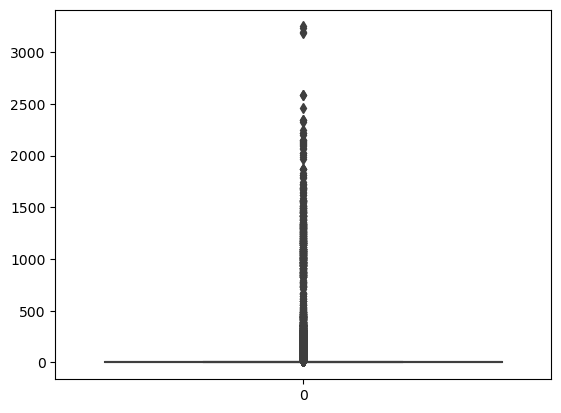

In [119]:
temp = sigdata.flatten()
sns.boxplot(temp)

In [59]:
df.dropna(inplace=True)
df_gen = df[df['Mode'] == 'Gen']
df_degen = df[df['Mode'] != 'Gen']

In [31]:
exp_list = list(df['Exp'].unique())

In [64]:
df_gen.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,MeanIR,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR
1,18_09_2024_2gSodium,01_Full,Gen,1,18.607635,529.772664,0,0.0,0.0,0.0,...,186.031067,363.806711,0,0.0,0.0,0.0,2079,1.669564,1.452365,14560
2,18_09_2024_2gSodium,01_Full,Gen,2,16.623215,113.9463,0,0.0,0.0,0.0,...,186.067932,363.843869,0,0.0,0.0,0.0,2048,1.669992,1.459481,14560
3,18_09_2024_2gSodium,01_Full,Gen,3,16.804977,114.391668,0,0.0,0.0,0.0,...,186.073975,363.870937,0,0.0,0.0,0.0,2063,1.66974,1.455439,14560
4,18_09_2024_2gSodium,01_Full,Gen,4,16.549622,113.642946,0,0.0,0.0,0.0,...,185.962265,363.666281,0,0.0,0.0,0.0,2038,1.670121,1.457063,14560
5,18_09_2024_2gSodium,01_Full,Gen,5,16.701035,114.150767,0,0.0,0.0,0.0,...,186.091309,363.959276,0,0.0,0.0,0.0,2049,1.671103,1.463362,14560


In [60]:
df_degen.groupby("Exp")['Frame'].max(), df_degen.groupby("Exp")['Frame'].min()

(Exp
 18_09_2024_2gSodium    4937
 20_09_2024_2gSodium    5100
 24_10_2024_2gSodium    4958
 Name: Frame, dtype: int64,
 Exp
 18_09_2024_2gSodium    1270
 20_09_2024_2gSodium    1400
 24_10_2024_2gSodium    1250
 Name: Frame, dtype: int64)

In [40]:
# Load Smoke Concentration data
exp1_conc = pd.read_csv("ConcInterpExp1.csv")
exp2_conc = pd.read_csv("ConcInterpExp2.csv")
exp3_conc = pd.read_csv("ConcInterpExp3.csv")

In [47]:
def findrange(dat):
    minval = dat.min()
    maxval = dat.max()
    print("Min: ", minval, "Max: ", maxval, "Range: ", maxval-minval)

In [65]:
findrange(exp1_conc['Time'])
findrange(exp2_conc['Time'])
findrange(exp3_conc['Time'])

Min:  127 Max:  3732 Range:  3605
Min:  140 Max:  3750 Range:  3610
Min:  125 Max:  3762 Range:  3637


In [62]:
len(df_degen[df_degen['Exp'] == '18_09_2024_2gSodium'])

3668

<Axes: ylabel='MeanSig'>

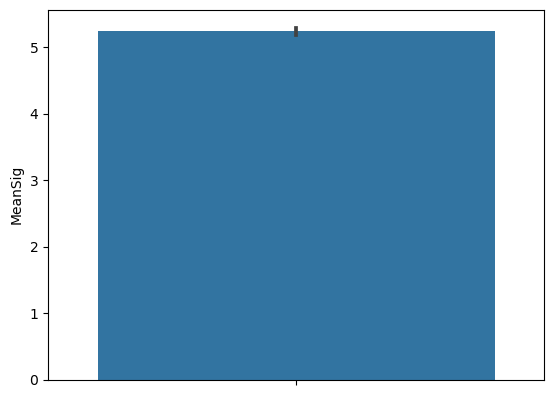

In [63]:
sns.barplot(data=df_degen[df_degen['Exp'] == '18_09_2024_2gSodium'], y='MeanSig')